# Spam Detection with Machine Learning

In [2]:
##### IMPORT CELL #####

import zipfile
import chardet
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from email import message_from_bytes
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer

#######################

## 1. Data pre-processing

In [3]:
##### 1.1 Get data and decode it #####

z = zipfile.ZipFile("spam1-train.zip")
emails = []
labels = []
errors, error_index = 0, []

for i, filename in enumerate(z.namelist()[:-1]):
    try:
        content_bin = z.read(filename)
        encoding = chardet.detect(content_bin)["encoding"]
        content = content_bin.decode(encoding if encoding != None else 'ascii')
        emails += [content]
        labels += [int(filename[-1])]
    except UnicodeDecodeError:
        errors += 1
        error_index += [i]
        continue
print('Number of non-decoded sequences:', errors)
print('Percentage of non-decoded sequences:', round(errors/len(z.namelist()),4)*100, '%')
# Convert lists to numpy arrays
emails = np.array(emails)
labels = np.array(labels)

Number of non-decoded sequences: 18
Percentage of non-decoded sequences: 0.11 %


In [4]:
##### 1.2 Extract features from our mails -> bag-of-words #####

vectorizer = CountVectorizer(min_df=5, strip_accents='ascii', stop_words='english', token_pattern=r'\b[a-zA-Z]+\b', max_features=10000)
features_train = vectorizer.fit_transform(emails)
features_train = features_train.toarray()
print(f'{features_train.shape = }')
# Retrieve the vocaulary list
vocabulary = vectorizer.get_feature_names_out()
print(f'Vocabulary length: {len(vocabulary)}')

features_train.shape = (16644, 10000)
Vocabulary length: 10000


In [5]:
##### 1.3 Normalization #####

scaler = StandardScaler()
features = scaler.fit_transform(features_train)
print(f'{features_train.shape = }')

features_train.shape = (16644, 10000)


In [7]:
# np.save('features_train1.npy', features_train)
# np.save('labels1.npy', labels)
features_train = np.load('features_train1.npy')
labels = np.load('labels1.npy')

## 2. Model training (SVM)

### 2.1 Train any model using 5-fold cross-validation

In [6]:
def train_evaluate(model, features, labels, model_name='base-model', n_splits=5):
    # K-Fold CV
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    accuracy_list, var_list = [], []
    
    # Training + metrics
    for idx_train, idx_eval in kf.split(features):
        X_train, X_eval, y_train, y_eval = features[idx_train], features[idx_eval], labels[idx_train], labels[idx_eval]
        # Fit the model
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.predict(X_eval)
        # Evaluate (accuracy and F1-score)
        acc = accuracy_score(y_eval, y_pred)
        accuracy_list += [acc*len(y_eval)]
        var_list += [acc]
        
    # Compute CV_score
    cvscore = sum(accuracy_list)/len(labels)
    variance = np.std(var_list)
    print(f'CV-score of {model_name}: CV-score = {cvscore:.3f}, Variance = {variance:.4f}')

    # Train the model on the whole Train dataset
    model.fit(features, labels)
    
    return cvscore, variance

`CV-score of SVC(C=1): 0.818`. We loose $10\%$ of CV-score if we remove `per_spammy` from `features`.

## 3. Model Selection

### 3.1 Hyperparameter tunning

In [75]:
# Hyperparameters to tune
Cs = [0.1, 1, 10, 100]
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
degrees = [2, 3, 4, 5]

In [76]:
def plot_tunning(kernel, degrees, Cs, cvscores, variances):
    fig = plt.figure(figsize=(12, 4))
    for i in range(len(degrees)):
        # CV-score
        plt.subplot(121)
        plt.plot(Cs, cvscores[i], label=f'd={degrees[i]}')
        plt.scatter(Cs[cvscores.flatten().argmax()%len(Cs)], cvscores.max(), c='r')
        plt.xscale('log')
        plt.xticks(Cs)
        plt.title(fr'CV-score=$\bf{cvscores.max():.3f}$  |  C={Cs[cvscores.flatten().argmax()%len(Cs)]}, d={degrees[cvscores.flatten().argmax()//len(Cs)]}')
        plt.legend()
        # Variance
        plt.subplot(122)
        plt.plot(Cs, variances[i], label=f'd={degrees[i]}')
        plt.scatter(Cs[variances.flatten().argmin()%len(Cs)], variances.min(), c='r')
        plt.xscale('log')
        plt.xticks(Cs)
        plt.title('Variance')
        plt.legend()
    _ = fig.supxlabel(kernel)

def get_cvscores_variances(kernel, degrees, Cs, d=True):
    if d:
        # Objects
        cvscores, variances = np.zeros((len(degrees), len(Cs))), np.zeros((len(degrees), len(Cs)))
        # Compute mectrics
        for j, degree in enumerate(degrees):
            for k, C in enumerate(Cs):
                cvscores[j, k], variances[j, k] = train_evaluate(
                    SVC(C=C, kernel=kernel, degree=degree), 
                    features, 
                    labels, 
                    f'SVC({C=}, {kernel=}, {degree=})'
                    )
        plot_tunning(kernel, degrees, Cs, cvscores, variances)
    else:
        # Objects
        cvscores, variances = np.zeros((len(degrees), len(Cs))), np.zeros((len(degrees), len(Cs)))
        # Compute mectrics
        for j, degree in enumerate(degrees):
            for k, C in enumerate(Cs):
                cvscores[j, k], variances[j, k] = train_evaluate(
                    SVC(C=C, kernel=kernel, degree=degree), 
                    features, 
                    labels, 
                    f'SVC({C=}, {kernel=}, {degree=})'
                    )
        plot_tunning(kernel, degrees, Cs, cvscores, variances)
    return cvscores, variances

CV-score of SVC(C=0.1, kernel='linear', degree=2): CV-score = 0.791, Variance = 0.0085
CV-score of SVC(C=1, kernel='linear', degree=2): CV-score = 0.792, Variance = 0.0082
CV-score of SVC(C=10, kernel='linear', degree=2): CV-score = 0.792, Variance = 0.0082
CV-score of SVC(C=100, kernel='linear', degree=2): CV-score = 0.791, Variance = 0.0081
CV-score of SVC(C=0.1, kernel='linear', degree=3): CV-score = 0.791, Variance = 0.0085
CV-score of SVC(C=1, kernel='linear', degree=3): CV-score = 0.792, Variance = 0.0082
CV-score of SVC(C=10, kernel='linear', degree=3): CV-score = 0.792, Variance = 0.0082
CV-score of SVC(C=100, kernel='linear', degree=3): CV-score = 0.791, Variance = 0.0081
CV-score of SVC(C=0.1, kernel='linear', degree=4): CV-score = 0.791, Variance = 0.0085
CV-score of SVC(C=1, kernel='linear', degree=4): CV-score = 0.792, Variance = 0.0082
CV-score of SVC(C=10, kernel='linear', degree=4): CV-score = 0.792, Variance = 0.0082
CV-score of SVC(C=100, kernel='linear', degree=4): C

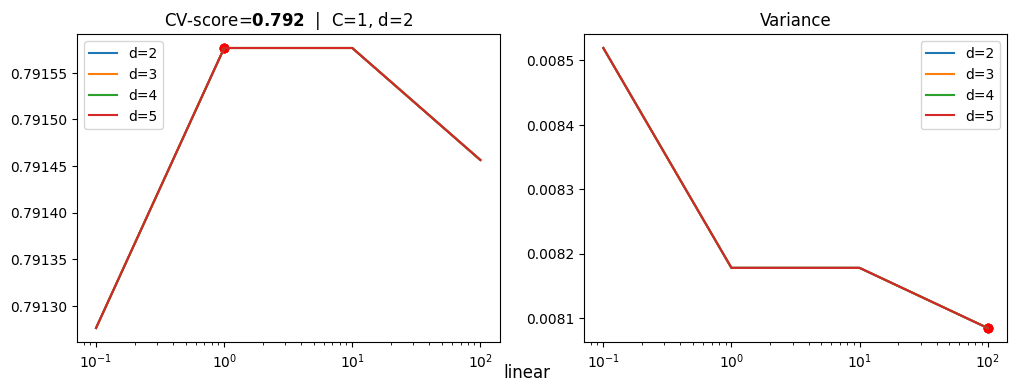

In [61]:
cvscores_linear, variances_linear = get_cvscores_variances('linear', degrees, Cs)

CV-score of SVC(C=0.1, kernel='poly', degree=2): CV-score = 0.614, Variance = 0.0079
CV-score of SVC(C=1, kernel='poly', degree=2): CV-score = 0.617, Variance = 0.0079
CV-score of SVC(C=10, kernel='poly', degree=2): CV-score = 0.618, Variance = 0.0079
CV-score of SVC(C=100, kernel='poly', degree=2): CV-score = 0.618, Variance = 0.0074
CV-score of SVC(C=100, kernel='poly', degree=3): CV-score = 0.743, Variance = 0.0119
CV-score of SVC(C=0.1, kernel='poly', degree=4): CV-score = 0.611, Variance = 0.0076
CV-score of SVC(C=1, kernel='poly', degree=4): CV-score = 0.624, Variance = 0.0080
CV-score of SVC(C=10, kernel='poly', degree=4): CV-score = 0.633, Variance = 0.0083
CV-score of SVC(C=100, kernel='poly', degree=4): CV-score = 0.641, Variance = 0.0103
CV-score of SVC(C=0.1, kernel='poly', degree=5): CV-score = 0.657, Variance = 0.0088
CV-score of SVC(C=1, kernel='poly', degree=5): CV-score = 0.683, Variance = 0.0097
CV-score of SVC(C=10, kernel='poly', degree=5): CV-score = 0.695, Varianc

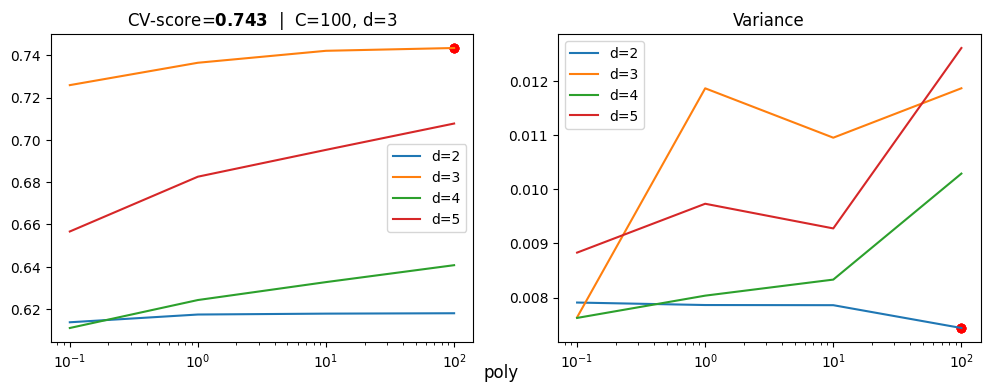

In [68]:
cvscores_poly, variances_poly = get_cvscores_variances('poly', degrees, Cs)

CV-score of SVC(C=0.1, kernel='rbf', degree=2): CV-score = 0.806, Variance = 0.0063
CV-score of SVC(C=1, kernel='rbf', degree=2): CV-score = 0.812, Variance = 0.0064
CV-score of SVC(C=10, kernel='rbf', degree=2): CV-score = 0.819, Variance = 0.0053
CV-score of SVC(C=100, kernel='rbf', degree=2): CV-score = 0.823, Variance = 0.0066
CV-score of SVC(C=0.1, kernel='rbf', degree=3): CV-score = 0.806, Variance = 0.0063
CV-score of SVC(C=1, kernel='rbf', degree=3): CV-score = 0.812, Variance = 0.0064
CV-score of SVC(C=10, kernel='rbf', degree=3): CV-score = 0.819, Variance = 0.0053
CV-score of SVC(C=100, kernel='rbf', degree=3): CV-score = 0.823, Variance = 0.0066
CV-score of SVC(C=0.1, kernel='rbf', degree=4): CV-score = 0.806, Variance = 0.0063
CV-score of SVC(C=1, kernel='rbf', degree=4): CV-score = 0.812, Variance = 0.0064
CV-score of SVC(C=10, kernel='rbf', degree=4): CV-score = 0.819, Variance = 0.0053
CV-score of SVC(C=100, kernel='rbf', degree=4): CV-score = 0.823, Variance = 0.0066
C

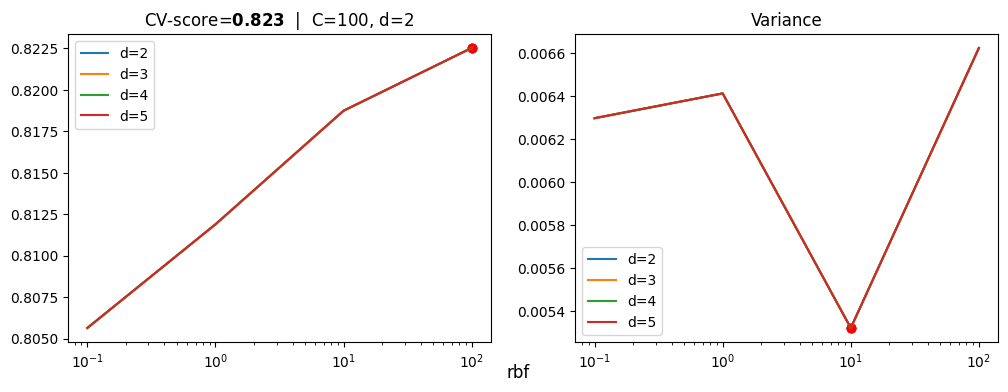

In [69]:
cvscores_rbf, variances_rbf = get_cvscores_variances('rbf', degrees, Cs)

CV-score of SVC(C=0.1, kernel='sigmoid', degree=2): CV-score = 0.687, Variance = 0.0124
CV-score of SVC(C=1, kernel='sigmoid', degree=2): CV-score = 0.676, Variance = 0.0112
CV-score of SVC(C=10, kernel='sigmoid', degree=2): CV-score = 0.674, Variance = 0.0112
CV-score of SVC(C=100, kernel='sigmoid', degree=2): CV-score = 0.674, Variance = 0.0113
CV-score of SVC(C=0.1, kernel='sigmoid', degree=3): CV-score = 0.687, Variance = 0.0124
CV-score of SVC(C=1, kernel='sigmoid', degree=3): CV-score = 0.676, Variance = 0.0112
CV-score of SVC(C=10, kernel='sigmoid', degree=3): CV-score = 0.674, Variance = 0.0112
CV-score of SVC(C=100, kernel='sigmoid', degree=3): CV-score = 0.674, Variance = 0.0113
CV-score of SVC(C=0.1, kernel='sigmoid', degree=4): CV-score = 0.687, Variance = 0.0124
CV-score of SVC(C=1, kernel='sigmoid', degree=4): CV-score = 0.676, Variance = 0.0112
CV-score of SVC(C=10, kernel='sigmoid', degree=4): CV-score = 0.674, Variance = 0.0112
CV-score of SVC(C=100, kernel='sigmoid', 

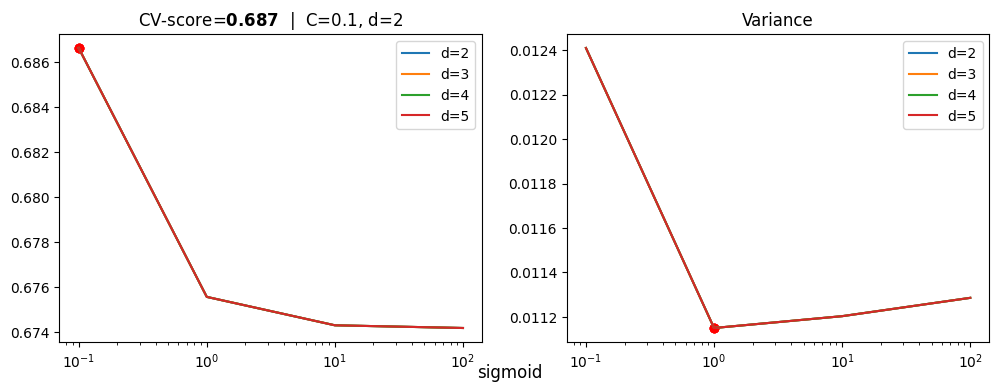

In [70]:
cvscores_sigmoid, variances_sigmoid = get_cvscores_variances('sigmoid', degrees, Cs)

It appears `rbf` is the best kernel, with best CV-score and low variance. Let's find the best $C$.

CV-score of SVC(C=0.01, kernel='rbf', degree=3): CV-score = 0.800, Variance = 0.0077
CV-score of SVC(C=0.1, kernel='rbf', degree=3): CV-score = 0.806, Variance = 0.0063
CV-score of SVC(C=1, kernel='rbf', degree=3): CV-score = 0.812, Variance = 0.0064
CV-score of SVC(C=10, kernel='rbf', degree=3): CV-score = 0.819, Variance = 0.0053
CV-score of SVC(C=100, kernel='rbf', degree=3): CV-score = 0.823, Variance = 0.0066
CV-score of SVC(C=1000, kernel='rbf', degree=3): CV-score = 0.829, Variance = 0.0057
CV-score of SVC(C=10000, kernel='rbf', degree=3): CV-score = 0.831, Variance = 0.0051


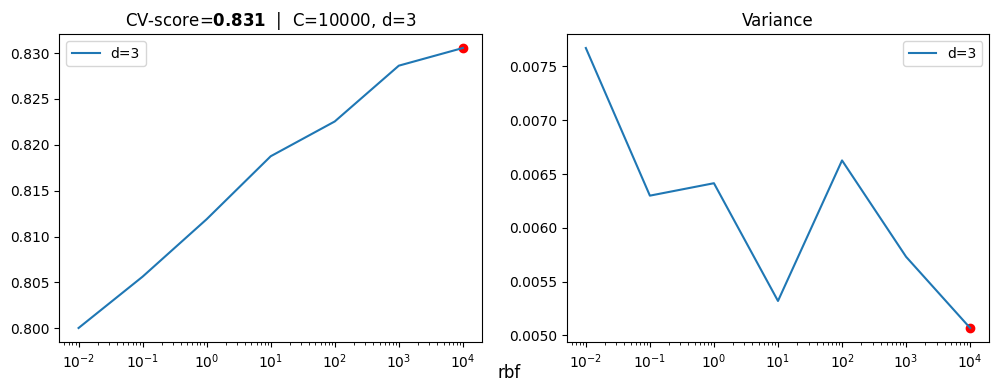

In [80]:
cvscores_final, variances_final = get_cvscores_variances('rbf', degrees=[3], Cs=[0.01, 0.1, 1, 10, 100, 1000, 10000], d=False)

We choose the following model: `SVC(C=10000, kernel='rbf')`

### 3.2 Final model fitting

In [6]:
##### Get fine-tunned SVC model #####

model_svc = SVC(C=10000, kernel='rbf')
_ = train_evaluate(model_svc, features, labels, model_name="SVC(C=10000, kernel='rbf')", n_splits=5)

CV-score of SVC(C=10000, kernel='rbf'): CV-score = 0.831, Variance = 0.0051


In [8]:
##### Get basic SVC model #####

model_svc_basic = SVC()
_ = train_evaluate(model_svc_basic, features, labels, model_name="SVC()", n_splits=5)

CV-score of SVC(): CV-score = 0.812, Variance = 0.0064


In [7]:
##### Get basic Decision Tree model #####

from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier()
_ = train_evaluate(model_dt, features, labels, model_name="DTC()", n_splits=5)

CV-score of DTC(): CV-score = 0.792, Variance = 0.0068


In [8]:
##### Get basic Random Forest model #####

from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
_ = train_evaluate(model_rf, features, labels, model_name="RFC()", n_splits=5)

CV-score of RFC(): CV-score = 0.837, Variance = 0.0070


In [7]:
##### Get basic Gradient Boosting model #####

from sklearn.ensemble import HistGradientBoostingClassifier

model_gb = HistGradientBoostingClassifier()
_ = train_evaluate(model_gb, features_train, labels, model_name="GBC()", n_splits=5)

CV-score of GBC(): CV-score = 0.983, Variance = 0.0031


## 4. Test dataset (don't forget to scale test data)

### 4.1 Process of test dataset

In [8]:
##### 1.1 Get data and decode it #####

z_test = zipfile.ZipFile("spam1-test.zip")
emails_test = []
errors, decoded_indices = 0, np.ones(len(z_test.namelist()))

for i, filename in enumerate(z_test.namelist()):
    try:
        content_bin = z_test.read(filename)
        encoding = chardet.detect(content_bin)["encoding"]
        content = content_bin.decode(encoding) if encoding != None else 'ascii'
        emails_test += [content]
    except UnicodeDecodeError:
        errors += 1
        decoded_indices[i] = 0 
        continue
print('Number of non-decoded sequences:', errors)
print('Percentage of non-decoded sequences:', round(errors/len(z_test.namelist()),4)*100, '%')
# Convert lists to numpy arrays
emails_test = np.array(emails_test)
decoded_indices = decoded_indices.astype(bool)


##### Bag-of-words extraction using the same vectorizer as train #####

features_test = vectorizer.transform(emails_test)
features_test = features_test.toarray()
print(f'{features_test.shape = }')
# Retrieve the vocaulary list
vocabulary_test = vectorizer.get_feature_names_out()
print(f'Vocabulary length: {len(vocabulary_test)}')


##### 1.3 Normalization #####

features_test = scaler.transform(features_test)
print(f'{features_test.shape = }')

Number of non-decoded sequences: 8
Percentage of non-decoded sequences: 0.05 %
features_test.shape = (15043, 10000)
Vocabulary length: 10000
features_test.shape = (15043, 10000)


### 4.2 Prediction of SVC on test dataset

In [9]:
##### Predict of test dataset with SVC #####

X_test = features_test
y_pred = model_gb.predict(X_test)

In [10]:
submission = []
i_corr = 0
# Write the prediction as expected output
for i, filename in enumerate(z_test.namelist()):
    if decoded_indices[i]:
        submission += [filename + ';' + y_pred[i-i_corr].astype(str)]
    else: # if email hasn't been decoded and thus predicted, we randomly choose its class
        submission += [filename + ';' + str(np.random.randint(2))]
        i_corr += 1
print(f'Length of our submission: {len(submission)} | Length of zip file: {len(z_test.namelist())}')
# Save the output as a text file
np.savetxt('output1_gb_allfeatures.csv', np.array(submission), fmt='%s', delimiter=',')

Length of our submission: 15051 | Length of zip file: 15051
